In [1]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

In [2]:
# define the model parameters
num_validation = 5000
num_feature = 2000
batch_size = 20
epoch = 300
lr = 0.1

In [11]:
def read_data(dataset, category):
    '''
    Import the data from the directory
    
    Argument:
    dataset: "train" or "test"
    category: "pos" or "neg"
    
    Return: 
    result_list: a list of strings
    '''
    result_list = []
    path = str(dataset)+'/'+str(category)
    entries = os.listdir(path)
    for txt in entries:
        #print(txt)
        with open(os.path.join(path, txt), encoding='utf-8') as f:
            text = f.readline().strip().lower()
            result_list.append(text)
    #result_list = np.array(result_list)
    return result_list

def data_preprocessing(num_feature,filename):
    '''
    Data preprocessing 
    
    Argument:
    filename(str): location and name of the file to store the training/val/test sets
    
    Return:
    store the training data, validation data, test data
    '''
    # read data
    train_pos = read_data('train', 'pos')
    train_neg = read_data('train', 'neg')
    test_neg = read_data('test', 'neg')
    test_pos = read_data('test', 'pos')
    
    # shuffle the training data
    np.random.seed(314)
    np.random.shuffle(train_pos)
    np.random.seed(314)
    np.random.shuffle(train_neg)
    
    # define validation data
    #num_validation
    #print((len(train_pos) - num_validation//2))
    # take 5000 samples as validation from the shuffled training dataset
    val_pos = train_pos[(len(train_pos) - num_validation//2):len(train_pos)]
    train_pos_final = train_pos[0:(len(train_pos) - num_validation//2)]
    val_neg = train_neg[(len(train_neg) - num_validation//2):len(train_neg)]
    train_neg_final = train_neg[0:(len(train_neg) - num_validation//2)]
    
    # combine pos and neg 
    X_train = train_pos_final + train_neg_final
    y_train = [1] * len(train_pos_final) + [0] * len(train_neg_final)
    y_train = np.array([y_train]).T
    X_val = val_pos + val_neg
    y_val = [1] * len(val_pos) + [0] * len(val_neg)
    y_val = np.array([y_val]).T
    X_test = test_pos + test_neg
    y_test = [1] * len(test_pos) + [0] * len(test_neg)
    y_test = np.array([y_test]).T
    
    # shuffle the training data
    np.random.seed(314)
    np.random.shuffle(X_train)
    np.random.seed(314)
    np.random.shuffle(y_train)
    
    # generate word2id dictionary
    vocab = dict()
    for sentence in X_train:
        for w in sentence.split():
            if w in vocab:
                vocab[w] += 1
            else:
                vocab[w] = 1
    vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)
    
    word2id = {}
    i = 0
    for tp in vocab:
        word2id[tp[0]] = i
        i+= 1
        if i == num_feature:
            break
    
    # define feature matrix
    X_train_matrix = []
    for sample in X_train: 
        repr_sample = np.zeros(num_feature,dtype=int)
        tokens = set(sample.split())
        for tk in tokens:
            if tk in word2id:
                repr_sample[word2id[tk]] = 1
        X_train_matrix.append(repr_sample)
    X_train_matrix = np.array(X_train_matrix) 
    
    X_val_matrix = []
    for sample in X_val: 
        repr_sample = np.zeros(num_feature,dtype=int)
        tokens = set(sample.split())
        for tk in tokens:
            if tk in word2id:
                repr_sample[word2id[tk]] = 1
        X_val_matrix.append(repr_sample)
    X_val_matrix = np.array(X_val_matrix)
    
    X_test_matrix = []
    for sample in X_test: 
        repr_sample = np.zeros(num_feature,dtype=int)
        tokens = set(sample.split())
        for tk in tokens:
            if tk in word2id:
                repr_sample[word2id[tk]] = 1
        X_test_matrix.append(repr_sample)
    X_test_matrix = np.array(X_test_matrix)
    
    # store data
    pickle.dump((X_train_matrix, y_train, X_val_matrix, y_val, X_test_matrix, y_test), open(filename, "wb"))


In [9]:
def sigmoid(x):
    '''
    Compute the sigmoid function for x
    
    Argument: 
    x: a numpy array
    
    Return: 
    sigmoid of x
    '''
    return 1/(1+np.exp(-x))

def classify(predictions):
    """
    Compute the binary class label 
    
    Argument:
    predictions: a numpy array of probablities
    
    Return:
    the binary class label, 0 or 1
    """
    return [1 if p>0.5 else 0 for p in predictions]

def accuracy(predicted_labels, actual_labels):
    '''
    Compute the accuracy of prediction
    
    Argument:
    predicted_labels: the predicted labels
    actual_labels: the true labels 
    
    Return:
    the accuracy
    '''
    agreement = 0
    for i in range(len(predicted_labels)):
        if predicted_labels[i] == actual_labels[i]:
            agreement+=1
    return agreement/len(predicted_labels)

def cross_entropy_loss(x,y,w,b):
    '''
    Compute the loss function
    
    Argument:
    x: feature matrix
    y: the true labels
    w: weights 
    b: bias
    
    Return:
    the loss
    '''
    predicted_prob = sigmoid(np.dot(x,w)+b)
    return np.mean(-(y * np.log(predicted_prob) + (1 - y) * np.log(1 - predicted_prob)))
def prediction(x, w, b):
    '''
    Compute the predicted probability
    
    Argument:
    x: feature matrix
    w: weights
    b: bias
    
    Return:
    predicted probablity 
    '''
    return sigmoid(np.dot(x,w)+b)

def logistic_regression_with_validation(x_train,y_train,x_val, y_val,batch_size,epoch,learning_rate):
    '''
    Train the logistic regression model with hold-out validation
    
    Argument:
    x_train: feature matrix for training dataset
    y_train: true labels for training dataset
    x_val: feature matrix for validation dataset
    y_val: true labels for validation dataset
    batch_size: the batch size for gradient decent
    epoch: the iteration number
    learning_rate: the decending rate for gradient decent
    
    Return:
    val_acc_list: a numpy array for validation set accuracy, Nepoch * 1
    train_acc_list: a numpy array for training set accuracy, Nepoch * 1
    best_w: the optimized weights
    best_b: the optimized bias
    '''
    val_acc_list = np.zeros((epoch))
    train_acc_list = np.zeros((epoch))
    w_list = np.zeros((epoch,x_train.shape[1]))
    b_list = np.zeros((epoch))
    #w,b = initialize_para(x_train.shape[1])
    w = np.array([np.random.uniform(-0.5,0.5,x_train.shape[1])]).T
    b = np.array([np.random.uniform(-0.5,0.5,1)])
    for i in range(epoch):
        print("epoch",i)
        np.random.seed(31)
        np.random.shuffle(x_train)
        np.random.seed(31)
        np.random.shuffle(y_train)
        for j in range(x_train.shape[0]//batch_size):
            x_batch = x_train[(batch_size*j):(batch_size*(j+1))]
            y_batch = y_train[(batch_size*j):(batch_size*(j+1))]
            
            dw = np.dot(x_batch.T,(prediction(x_batch,w,b)-y_batch))/batch_size
            db = np.mean((sigmoid(np.dot(x_batch,w)+b)-y_batch))
            w -= learning_rate*dw
            b -= learning_rate*db
            
            #print("we are in batch # " + str(j) + " now")            
            #train_accuracy = accuracy(classify(sigmoid(np.dot(x_train,w)+b)), y_train)
            #print('train acc',train_accuracy) 
            #val_accuracy = accuracy(classify(sigmoid(np.dot(x_val,w)+b)), y_val)
            #print('val acc',val_accuracy)


        # validation
        loss = cross_entropy_loss(x_train, y_train, w, b)
        print('train loss',loss)        
        loss = cross_entropy_loss(x_val, y_val, w, b)
        print('val loss',loss)        
        train_accuracy = accuracy(classify(prediction(x_train,w,b)), y_train)
        print('train acc',train_accuracy)
        val_accuracy = accuracy(classify(prediction(x_val,w,b)), y_val)
        print('val acc',val_accuracy)
        train_acc_list[i] = train_accuracy
        val_acc_list[i] = val_accuracy
        w_list[i] = w.reshape(x_train.shape[1])
        b_list[i] = b
        
    best_model_idx = np.argmax(val_acc_list)
    #print(best_model_idx)
    best_w = w_list[best_model_idx]
    best_b = b_list[best_model_idx]
    
    return val_acc_list, train_acc_list, best_w, best_b

def test_pred(x_test,y_test,w,b):
    '''
    Compute the test accuracy
    
    Argument:
    x_test: feature matrix
    y_test: true labels 
    w: weights
    b: bias
    
    Return:
    test_accuracy: the accuracy for test dataset
    '''
    test_loss =  cross_entropy_loss(x_test, y_test, w, b)
    test_accuracy = accuracy(classify(prediction(x_test,w,b)), y_test)
    return test_accuracy

In [12]:
# data
data_preprocessing(num_feature,"data.pkl")
X_train, y_train, X_val, y_val, X_test, y_test = pickle.load( open("data.pkl", "rb"))

In [10]:
# main 
val_acc_list, train_acc_list, best_w, best_b = logistic_regression_with_validation(X_train,
                                                                                   y_train,
                                                                                   X_val, 
                                                                                   y_val,
                                                                                   batch_size,
                                                                                   epoch,
                                                                                   lr)
test_accuracy = test_pred(X_test,y_test,best_w,best_b)

epoch 0
train loss 0.43175581036
val loss 0.472187424449
train acc 0.80675
val acc 0.7884
epoch 1
train loss 0.367574155061
val loss 0.418706098794
train acc 0.841
val acc 0.8116
epoch 2
train loss 0.329868816889
val loss 0.388525508146
train acc 0.86155
val acc 0.8262
epoch 3
train loss 0.317915392018
val loss 0.382544867815
train acc 0.86605
val acc 0.835
epoch 4
train loss 0.306062691468
val loss 0.375076553265
train acc 0.87115
val acc 0.8354
epoch 5
train loss 0.292879861105
val loss 0.365932173198
train acc 0.87875
val acc 0.8396
epoch 6
train loss 0.285737989444
val loss 0.363239570628
train acc 0.88265
val acc 0.8436
epoch 7
train loss 0.282294998827
val loss 0.362780585828
train acc 0.88395
val acc 0.8424
epoch 8
train loss 0.275455066553
val loss 0.357646281936
train acc 0.8883
val acc 0.8474
epoch 9
train loss 0.279238574451
val loss 0.365113805524
train acc 0.88525
val acc 0.8418
epoch 10
train loss 0.270192757468
val loss 0.35811519647
train acc 0.8898
val acc 0.8488
epoch

train acc 0.8984
val acc 0.8444
epoch 91
train loss 0.25253296645
val loss 0.400265407606
train acc 0.8975
val acc 0.8414
epoch 92
train loss 0.2484677816
val loss 0.395069498935
train acc 0.89895
val acc 0.8444
epoch 93
train loss 0.248805239365
val loss 0.394830322166
train acc 0.8983
val acc 0.8448
epoch 94
train loss 0.249372940371
val loss 0.396221865319
train acc 0.89895
val acc 0.8448
epoch 95
train loss 0.252827244335
val loss 0.398620924897
train acc 0.8966
val acc 0.8432
epoch 96
train loss 0.25336877104
val loss 0.40190833013
train acc 0.896
val acc 0.8412
epoch 97
train loss 0.249170113177
val loss 0.397572543662
train acc 0.899
val acc 0.8406
epoch 98
train loss 0.248670361469
val loss 0.39614784799
train acc 0.89915
val acc 0.843
epoch 99
train loss 0.252217948439
val loss 0.399433172334
train acc 0.8964
val acc 0.8448
epoch 100
train loss 0.266862069832
val loss 0.418140623308
train acc 0.88775
val acc 0.8358
epoch 101
train loss 0.260559342201
val loss 0.406864061828
tr

/usr/local/Cellar/python3/3.5.2_1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log
/usr/local/Cellar/python3/3.5.2_1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in multiply


train loss nan
val loss 0.405410933014
train acc 0.8964
val acc 0.8418
epoch 124
train loss 0.248456794003
val loss 0.400933163208
train acc 0.89875
val acc 0.8408
epoch 125
train loss 0.249325814658
val loss 0.400045375255
train acc 0.8978
val acc 0.8432
epoch 126
train loss 0.248670895332
val loss 0.400658865535
train acc 0.89875
val acc 0.8414
epoch 127
train loss 0.25226902613
val loss 0.402154945446
train acc 0.89735
val acc 0.8442
epoch 128
train loss 0.248402585311
val loss 0.400706827857
train acc 0.8987
val acc 0.8416
epoch 129
train loss 0.249076631902
val loss 0.401502098308
train acc 0.8984
val acc 0.841
epoch 130
train loss 0.249572229202
val loss 0.403084875285
train acc 0.89795
val acc 0.8402
epoch 131
train loss 0.24924286391
val loss 0.401231917324
train acc 0.8997
val acc 0.8444
epoch 132
train loss 0.248677208928
val loss 0.400748075182
train acc 0.8991
val acc 0.8416
epoch 133
train loss 0.24994382998
val loss 0.40118473101
train acc 0.8986
val acc 0.845
epoch 134
t

train loss nan
val loss 0.404453508913
train acc 0.89795
val acc 0.8416
epoch 216
train loss nan
val loss 0.402663409016
train acc 0.8986
val acc 0.84
epoch 217
train loss 0.249840393503
val loss 0.402643746988
train acc 0.8974
val acc 0.8432
epoch 218
train loss 0.248448485464
val loss 0.401162881996
train acc 0.8989
val acc 0.8436
epoch 219
train loss 0.249109487886
val loss 0.403002331622
train acc 0.8985
val acc 0.8454
epoch 220
train loss nan
val loss 0.403423593066
train acc 0.89825
val acc 0.8422
epoch 221
train loss nan
val loss 0.401916051603
train acc 0.89885
val acc 0.843
epoch 222
train loss 0.249260598716
val loss 0.402278519321
train acc 0.8981
val acc 0.8414
epoch 223
train loss nan
val loss 0.401944063818
train acc 0.8981
val acc 0.8412
epoch 224
train loss 0.248991569343
val loss 0.401778015785
train acc 0.89825
val acc 0.842
epoch 225
train loss 0.255243206892
val loss 0.4070510442
train acc 0.89475
val acc 0.8434
epoch 226
train loss nan
val loss 0.404141264803
train

In [13]:
# (a)
test_accuracy
# 

0.85036

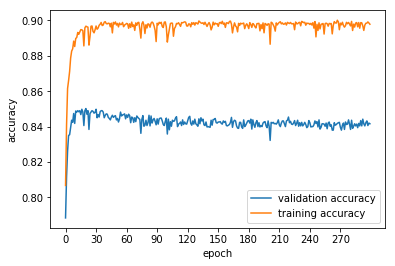

In [14]:
# (b)
# result plots
plt.plot(val_acc_list)
plt.plot(train_acc_list)
plt.legend(['validation accuracy', 'training accuracy'], loc='lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xticks(np.arange(0, epoch, step=30))
plt.show()

In [15]:
# (c) try different batch size
batch_size_list = [200, 2000, 20000]
for batch_size in batch_size_list:
    val_acc_list, train_acc_list, best_w, best_b = logistic_regression_with_validation(X_train,y_train,X_val, y_val,batch_size,epoch,lr)
    test_accuracy = test_pred(X_test,y_test,best_w,best_b)
    print('batch size:', batch_size, 'test accuracy:',test_accuracy)

epoch 0
train loss 0.828847857082
val loss 0.822085475765
train acc 0.6221
val acc 0.623
epoch 1
train loss 0.696899543439
val loss 0.697522376052
train acc 0.6782
val acc 0.6794
epoch 2
train loss 0.621631355999
val loss 0.626635930399
train acc 0.71455
val acc 0.7166
epoch 3
train loss 0.569566048165
val loss 0.581481497784
train acc 0.73835
val acc 0.7388
epoch 4
train loss 0.532550964731
val loss 0.548316758958
train acc 0.75525
val acc 0.7532
epoch 5
train loss 0.507158908714
val loss 0.528602720174
train acc 0.7664
val acc 0.7652
epoch 6
train loss 0.482199771684
val loss 0.504847229444
train acc 0.77875
val acc 0.7724
epoch 7
train loss 0.464489336528
val loss 0.488765515445
train acc 0.7873
val acc 0.781
epoch 8
train loss 0.450998229033
val loss 0.48097967486
train acc 0.79435
val acc 0.7844
epoch 9
train loss 0.435598958875
val loss 0.465488984673
train acc 0.80195
val acc 0.7914
epoch 10
train loss 0.424456221009
val loss 0.457332435413
train acc 0.80765
val acc 0.796
epoch 

train loss 0.274872769147
val loss 0.359551607944
train acc 0.88655
val acc 0.8484
epoch 91
train loss 0.274515492072
val loss 0.359552940754
train acc 0.88665
val acc 0.8484
epoch 92
train loss 0.274459737246
val loss 0.358569676027
train acc 0.88655
val acc 0.8486
epoch 93
train loss 0.273764070005
val loss 0.358794657854
train acc 0.88695
val acc 0.849
epoch 94
train loss 0.274203419595
val loss 0.361158560357
train acc 0.88655
val acc 0.8464
epoch 95
train loss 0.273045347946
val loss 0.358895546378
train acc 0.88725
val acc 0.8492
epoch 96
train loss 0.273043544106
val loss 0.358485430184
train acc 0.88695
val acc 0.8488
epoch 97
train loss 0.273008419952
val loss 0.360773675508
train acc 0.88715
val acc 0.8474
epoch 98
train loss 0.272078996861
val loss 0.3592598258
train acc 0.88745
val acc 0.8494
epoch 99
train loss 0.274519345147
val loss 0.364130698253
train acc 0.88685
val acc 0.8458
epoch 100
train loss 0.271619481855
val loss 0.359849223091
train acc 0.8878
val acc 0.8484


train acc 0.89365
val acc 0.8486
epoch 180
train loss 0.257430539915
val loss 0.365133661776
train acc 0.8945
val acc 0.8458
epoch 181
train loss 0.257286338941
val loss 0.364589175843
train acc 0.89415
val acc 0.848
epoch 182
train loss 0.257229861396
val loss 0.364578636386
train acc 0.8939
val acc 0.8478
epoch 183
train loss 0.258108074355
val loss 0.367355924549
train acc 0.89425
val acc 0.8478
epoch 184
train loss 0.257132101127
val loss 0.36464027542
train acc 0.8939
val acc 0.8486
epoch 185
train loss 0.256936326744
val loss 0.364873456931
train acc 0.8943
val acc 0.846
epoch 186
train loss 0.257061915426
val loss 0.364820383445
train acc 0.89375
val acc 0.8484
epoch 187
train loss 0.256707877545
val loss 0.365310941297
train acc 0.89445
val acc 0.8466
epoch 188
train loss 0.256638569635
val loss 0.365794599693
train acc 0.89435
val acc 0.8446
epoch 189
train loss 0.25652403772
val loss 0.36564565583
train acc 0.89405
val acc 0.8462
epoch 190
train loss 0.256435588858
val loss 0

train acc 0.8962
val acc 0.8444
epoch 269
train loss 0.251695605427
val loss 0.373283128501
train acc 0.89585
val acc 0.8448
epoch 270
train loss 0.251743396038
val loss 0.374118320779
train acc 0.89625
val acc 0.8436
epoch 271
train loss 0.251867458515
val loss 0.374607178855
train acc 0.8966
val acc 0.8434
epoch 272
train loss 0.251789445594
val loss 0.373281497723
train acc 0.896
val acc 0.8438
epoch 273
train loss 0.251538405027
val loss 0.374119672702
train acc 0.89595
val acc 0.8438
epoch 274
train loss 0.251495020111
val loss 0.373810829303
train acc 0.89595
val acc 0.8448
epoch 275
train loss 0.251688192823
val loss 0.375009206982
train acc 0.8961
val acc 0.8434
epoch 276
train loss 0.251524095693
val loss 0.373783020376
train acc 0.89605
val acc 0.8442
epoch 277
train loss 0.251507614829
val loss 0.37381889915
train acc 0.89585
val acc 0.8438
epoch 278
train loss 0.251340346109
val loss 0.374147420651
train acc 0.8958
val acc 0.8452
epoch 279
train loss 0.252150494502
val loss

train loss 0.508091916227
val loss 0.554407599448
train acc 0.7654
val acc 0.7472
epoch 59
train loss 0.505504102904
val loss 0.552199735634
train acc 0.7669
val acc 0.7474
epoch 60
train loss 0.502980419297
val loss 0.549386338278
train acc 0.7685
val acc 0.7486
epoch 61
train loss 0.50048065428
val loss 0.547324791188
train acc 0.76985
val acc 0.7502
epoch 62
train loss 0.498079482008
val loss 0.544763413306
train acc 0.77135
val acc 0.7504
epoch 63
train loss 0.495694349507
val loss 0.542660431607
train acc 0.7727
val acc 0.7512
epoch 64
train loss 0.493404937154
val loss 0.540302271064
train acc 0.77385
val acc 0.7526
epoch 65
train loss 0.491212534937
val loss 0.5390234278
train acc 0.7758
val acc 0.7554
epoch 66
train loss 0.488902569682
val loss 0.536189127453
train acc 0.7764
val acc 0.7552
epoch 67
train loss 0.486922884915
val loss 0.535177840833
train acc 0.77815
val acc 0.7584
epoch 68
train loss 0.484665765268
val loss 0.532723414947
train acc 0.77935
val acc 0.758
epoch 6

train acc 0.82755
val acc 0.8022
epoch 148
train loss 0.389965750663
val loss 0.444573802241
train acc 0.8287
val acc 0.8032
epoch 149
train loss 0.389245295819
val loss 0.443747213789
train acc 0.82895
val acc 0.8028
epoch 150
train loss 0.388553088815
val loss 0.442919676355
train acc 0.8286
val acc 0.803
epoch 151
train loss 0.387882247036
val loss 0.442393712523
train acc 0.8295
val acc 0.8034
epoch 152
train loss 0.387235131168
val loss 0.441506955571
train acc 0.8293
val acc 0.8034
epoch 153
train loss 0.386559074041
val loss 0.441031144436
train acc 0.82985
val acc 0.8048
epoch 154
train loss 0.385902083178
val loss 0.440534997585
train acc 0.8303
val acc 0.8048
epoch 155
train loss 0.385257546261
val loss 0.439881298353
train acc 0.83035
val acc 0.8054
epoch 156
train loss 0.384631973202
val loss 0.439180997608
train acc 0.83065
val acc 0.8058
epoch 157
train loss 0.383986848816
val loss 0.438968362403
train acc 0.83135
val acc 0.8056
epoch 158
train loss 0.383351522008
val los

train acc 0.85065
val acc 0.823
epoch 237
train loss 0.347071137486
val loss 0.406491103206
train acc 0.8506
val acc 0.8224
epoch 238
train loss 0.346750426143
val loss 0.406942202405
train acc 0.8508
val acc 0.8236
epoch 239
train loss 0.346389079317
val loss 0.40654071008
train acc 0.8512
val acc 0.8236
epoch 240
train loss 0.346023933382
val loss 0.40586323386
train acc 0.8513
val acc 0.823
epoch 241
train loss 0.345689473535
val loss 0.405665843632
train acc 0.85135
val acc 0.8234
epoch 242
train loss 0.345360659532
val loss 0.405452551746
train acc 0.85155
val acc 0.824
epoch 243
train loss 0.345031955461
val loss 0.40507299711
train acc 0.8518
val acc 0.8242
epoch 244
train loss 0.34489234212
val loss 0.405741562544
train acc 0.85195
val acc 0.8248
epoch 245
train loss 0.344381035705
val loss 0.404566134872
train acc 0.852
val acc 0.8244
epoch 246
train loss 0.344079758728
val loss 0.40410032758
train acc 0.85225
val acc 0.824
epoch 247
train loss 0.343786085208
val loss 0.403741

train acc 0.5357
val acc 0.534
epoch 27
train loss 1.04605869294
val loss 1.0667059544
train acc 0.5372
val acc 0.5352
epoch 28
train loss 1.0425878423
val loss 1.06339814109
train acc 0.5385
val acc 0.5366
epoch 29
train loss 1.03914799115
val loss 1.0601200154
train acc 0.539
val acc 0.5382
epoch 30
train loss 1.03573875425
val loss 1.05687120509
train acc 0.54025
val acc 0.5396
epoch 31
train loss 1.03235975194
val loss 1.05365134189
train acc 0.54165
val acc 0.5408
epoch 32
train loss 1.02901061008
val loss 1.05046006207
train acc 0.54285
val acc 0.5408
epoch 33
train loss 1.02569095994
val loss 1.04729700675
train acc 0.544
val acc 0.542
epoch 34
train loss 1.02240043818
val loss 1.04416182203
train acc 0.5452
val acc 0.543
epoch 35
train loss 1.01913868673
val loss 1.04105415912
train acc 0.54615
val acc 0.544
epoch 36
train loss 1.01590535277
val loss 1.03797367431
train acc 0.54705
val acc 0.5452
epoch 37
train loss 1.01270008863
val loss 1.03492002899
train acc 0.54805
val acc

train loss 0.823947335079
val loss 0.855097523812
train acc 0.62055
val acc 0.614
epoch 118
train loss 0.822215522342
val loss 0.853446539217
train acc 0.6217
val acc 0.6142
epoch 119
train loss 0.820495184083
val loss 0.851806467861
train acc 0.6224
val acc 0.6148
epoch 120
train loss 0.818786210859
val loss 0.850177206275
train acc 0.62305
val acc 0.615
epoch 121
train loss 0.817088494589
val loss 0.848558652278
train acc 0.6236
val acc 0.6166
epoch 122
train loss 0.815401928526
val loss 0.846950704958
train acc 0.62435
val acc 0.618
epoch 123
train loss 0.813726407243
val loss 0.845353264654
train acc 0.6249
val acc 0.619
epoch 124
train loss 0.81206182661
val loss 0.843766232934
train acc 0.62515
val acc 0.6198
epoch 125
train loss 0.810408083775
val loss 0.842189512575
train acc 0.62585
val acc 0.621
epoch 126
train loss 0.808765077141
val loss 0.840623007545
train acc 0.6266
val acc 0.622
epoch 127
train loss 0.807132706355
val loss 0.839066622986
train acc 0.62705
val acc 0.6224

train acc 0.675
val acc 0.6636
epoch 207
train loss 0.703920271078
val loss 0.740646506398
train acc 0.67555
val acc 0.6636
epoch 208
train loss 0.702901686556
val loss 0.739675474857
train acc 0.67585
val acc 0.664
epoch 209
train loss 0.701888414386
val loss 0.73870952182
train acc 0.67625
val acc 0.665
epoch 210
train loss 0.700880413853
val loss 0.737748608557
train acc 0.6768
val acc 0.6656
epoch 211
train loss 0.699877644633
val loss 0.73679269671
train acc 0.67675
val acc 0.6658
epoch 212
train loss 0.698880066795
val loss 0.735841748291
train acc 0.677
val acc 0.6662
epoch 213
train loss 0.697887640794
val loss 0.734895725673
train acc 0.6772
val acc 0.6668
epoch 214
train loss 0.696900327467
val loss 0.733954591589
train acc 0.6779
val acc 0.667
epoch 215
train loss 0.695918088027
val loss 0.733018309125
train acc 0.67825
val acc 0.6676
epoch 216
train loss 0.694940884063
val loss 0.732086841721
train acc 0.6785
val acc 0.6682
epoch 217
train loss 0.693968677528
val loss 0.731

train acc 0.708
val acc 0.6954
epoch 296
train loss 0.630250044543
val loss 0.670471336359
train acc 0.70865
val acc 0.696
epoch 297
train loss 0.629580583569
val loss 0.669834315135
train acc 0.7091
val acc 0.696
epoch 298
train loss 0.628913956325
val loss 0.669200004685
train acc 0.70935
val acc 0.6964
epoch 299
train loss 0.628250144517
val loss 0.668568387448
train acc 0.7097
val acc 0.6966
batch size: 20000 test accuracy: 0.70136
